In [1]:
import pandas as pd
import yfinance as yf

# Cargar el archivo largo
df = pd.read_csv("historical_prices_long.csv")

# 1. Lista de tickers únicos
unique_tickers = df['Ticker'].unique()

# 2. Obtener nombres de empresa solo una vez por ticker
ticker_to_name = {}
for ticker in unique_tickers:
    try:
        info = yf.Ticker(ticker).info
        ticker_to_name[ticker] = info.get("shortName", "")
    except Exception:
        ticker_to_name[ticker] = ""

# 3. Añadir la columna 'name' usando map
df['name'] = df['Ticker'].map(ticker_to_name)

# 4. Guardar el resultado
df.to_csv("historical_prices_long_with_names.csv", index=False)

# Mostrar las primeras filas para comprobar
print(df.head())

         Date Ticker      Close                   name
0  2020-05-20   CWEN  16.318478  Clearway Energy, Inc.
1  2020-05-21   CWEN  16.365170  Clearway Energy, Inc.
2  2020-05-22   CWEN  16.466335  Clearway Energy, Inc.
3  2020-05-26   CWEN  16.497459  Clearway Energy, Inc.
4  2020-05-27   CWEN  16.738695  Clearway Energy, Inc.


In [10]:
import datetime
from datetime import datetime, timedelta

end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

def choose_tickers():
    df = pd.read_csv("historical_prices_long_with_names.csv")
    if df.empty:
        print("❌ No se encontraron datos de acciones. Por favor, verifica la fuente de datos.")
        return [], []
    tickers = df['Ticker'].tolist()
    names = df['name'].tolist()

    # Ya no comprobamos con yfinance, asumimos que los tickers del CSV son válidos

    #tickers_validos = []
    #names_validos = []
    #for ticker, name in zip(tickers, names):
    #    try:
    #        data = yf.Ticker(ticker).history(period="1d")
    #        if data.empty:
    #            st.warning(f"⚠️ No hay datos históricos para {ticker} (API vacía)")
    #        else:
    #            tickers_validos.append(ticker)
    #            names_validos.append(name)
    #    except Exception as e:
    #        st.warning(f"⚠️ Error al acceder a {ticker}: {e}")
    #if not tickers_validos:
    #    print("❌ No se pudo obtener información de ningún ticker válido desde Yahoo Finance.")
    return tickers, names

def cargar_datos():
    tickers, names = choose_tickers()
    if not tickers:
        return pd.DataFrame(), [], []
    symbols = dict(zip(names, tickers))
    data = pd.DataFrame()

    # Leer precios históricos desde el CSV local
    try:
        df_prices = pd.read_csv("historical_prices_long_with_names.csv", parse_dates=["Date"])
    except Exception as e:
        print(f"❌ Error al leer 'historical_prices_long_with_names.csv': {e}")
        return pd.DataFrame(), [], []

    # Filtrar fechas según el rango global
    mask = (df_prices["Date"] >= start_date) & (df_prices["Date"] <= end_date)
    df_prices = df_prices.loc[mask]

    # Pivotar para tener empresas como columnas y fechas como índice
    # Suponemos que el CSV tiene columnas: Date, Ticker, Close
    df_pivot = df_prices.pivot(index="Date", columns="Ticker", values="Close")

    # Renombrar columnas a nombres de empresa si es posible
    ticker_to_name = dict(zip(tickers, names))
    df_pivot = df_pivot.rename(columns=ticker_to_name)

    # Solo mantener las empresas seleccionadas
    data = df_pivot[names].dropna(axis=0, how="any")

    if data.empty:
        print("❌ No se pudo cargar ningún dato de precios históricos desde el CSV.")

    return data, tickers, names

def optimizar_cartera(mean_returns, cov_matrix, perfil, volatilities, threshold=0.6):
    """
    Portfolio optimization with risk-adjusted constraints.
    
    Parameters:
    - mean_returns: Expected annualized returns for each asset
    - cov_matrix: Covariance matrix of asset returns
    - perfil: User's risk profile (e.g., "Riesgo mínimo", "Rentabilidad máxima")
    - volatilities: Annualized volatilities of assets (standard deviation of daily returns * sqrt(252))
    - threshold: Volatility level above which assets are considered highly unstable
    
    Business logic:
    - If an asset is highly volatile and the user has a conservative risk profile,
    that asset is either excluded or capped at a small weight.
    - Aggressive profiles are allowed to take on more risk, but weights are still limited for extremely volatile assets.
    """

    n = len(mean_returns)
    if n == 0:
        print("❌ No hay suficientes datos de retorno para calcular una cartera óptima.")
        return np.array([])

    # Objective functions for each risk profile.
    # These balance return and volatility in different proportions.
    def annualized_return(w):
        return np.sum(mean_returns * w) * 252

    def annualized_volatility(w):
        return np.sqrt(np.dot(w.T, np.dot(cov_matrix, w))) * np.sqrt(252)

    objetivos = {
        "Riesgo mínimo": lambda w: annualized_volatility(w),  # prioritize stability
        "Riesgo bajo": lambda w: 0.75*annualized_volatility(w) - 0.25*annualized_return(w),
        "Riesgo medio": lambda w: 0.50*annualized_volatility(w) - 0.50*annualized_return(w),
        "Riesgo alto": lambda w: 0.25*annualized_volatility(w) - 0.75*annualized_return(w),
        "Rentabilidad máxima": lambda w: -annualized_return(w)  # maximize return
    }

    # Define allocation bounds dynamically based on volatility and risk profile
    bounds = []
    for i in range(n):
        vol = volatilities[i]
        
        # If asset is too volatile, limit or exclude it depending on profile
        if vol > threshold:
            if perfil in ["Riesgo mínimo", "Riesgo bajo"]:
                bounds.append((0, 0))  # exclude entirely for conservative users
            elif perfil == "Riesgo medio":
                bounds.append((0, 0.1))  # allow up to 10%
            else:
                bounds.append((0, 0.2))  # aggressive: allow up to 20%
        else:
            bounds.append((0, 1))  # normal allocation range

    if all(b[1] == 0 for b in bounds):
        print("❌ Todos los activos han sido excluidos por ser demasiado volátiles para tu perfil de riesgo. Intenta con un perfil más arriesgado o revisa los datos.")
        return np.array([])

    # Initial equal weight guess
    w0 = np.ones(n) / n
    
    # Total weight constraint: sum of allocations must equal 1 (100%)
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

    # Minimize the selected objective
    result = minimize(objetivos[perfil], w0, bounds=bounds, constraints=constraints)
    return result.x


## Perfil: Riesgo mínimo
### 📌 Composición de la cartera:
                            Empresa  Porcentaje
0           Republic Services, Inc.       27.30
1              Electronic Arts Inc.       11.21
2                      Pfizer, Inc.       10.82
3   NorthWestern Energy Group, Inc.        9.34
4              FTI Consulting, Inc.        8.46
5                 Brady Corporation        6.42
6      New York Times Company (The)        5.14
7               Entergy Corporation        3.69
8           Trio-Tech International        3.22
9          Werner Enterprises, Inc.        2.86
10                 ReposiTrak, Inc.        2.80
11                    Pro-Dex, Inc.        2.11
12    Adtalem Global Education Inc.        1.79
13                    Corteva, Inc.        1.43
14      Huron Consulting Group Inc.        1.01
15           Marten Transport, Ltd.        0.87
16                    Alphabet Inc.        0.55
17                First Solar, Inc.        0.49
18  Boston Beer Company, Inc.

C:\Users\David\AppData\Local\Temp\ipykernel_31632\3747642941.py:108: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vol = volatilities[i]


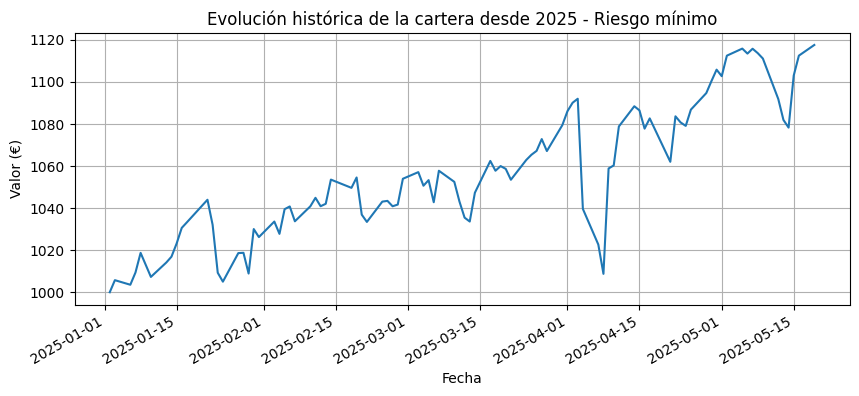

📈 Rentabilidad final estimada: 1117.45 €
📉 Máximo drawdown: -7.62% entre 2025-04-03 y 2025-04-08
🔎 Rentabilidad acumulada: 11.75%
--------------------------------------------------

## Perfil: Riesgo bajo
### 📌 Composición de la cartera:
                         Empresa  Porcentaje
0        Republic Services, Inc.       37.76
1  Adtalem Global Education Inc.       13.31
2    Huron Consulting Group Inc.       12.25
3              EMCOR Group, Inc.       12.18
4               ReposiTrak, Inc.       10.77
5                  Pro-Dex, Inc.        6.50
6     Federal Signal Corporation        3.93
7              First Solar, Inc.        2.44
8            Entergy Corporation        0.86


C:\Users\David\AppData\Local\Temp\ipykernel_31632\3747642941.py:108: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vol = volatilities[i]


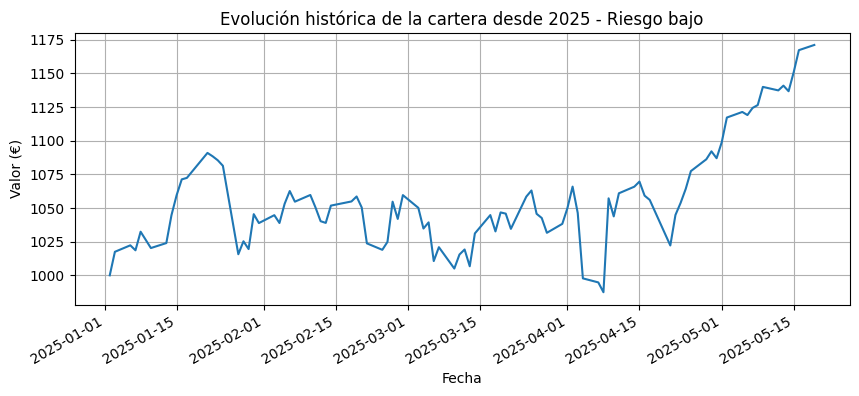

📈 Rentabilidad final estimada: 1171.10 €
📉 Máximo drawdown: -9.49% entre 2025-01-21 y 2025-04-08
🔎 Rentabilidad acumulada: 17.11%
--------------------------------------------------

## Perfil: Riesgo medio
### 📌 Composición de la cartera:
                         Empresa  Porcentaje
0  Adtalem Global Education Inc.       32.99
1               ReposiTrak, Inc.       24.81
2              EMCOR Group, Inc.       24.46
3    Huron Consulting Group Inc.        9.43
4                  Pro-Dex, Inc.        7.93
5        Coronado Global Res Inc        0.38


C:\Users\David\AppData\Local\Temp\ipykernel_31632\3747642941.py:108: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vol = volatilities[i]


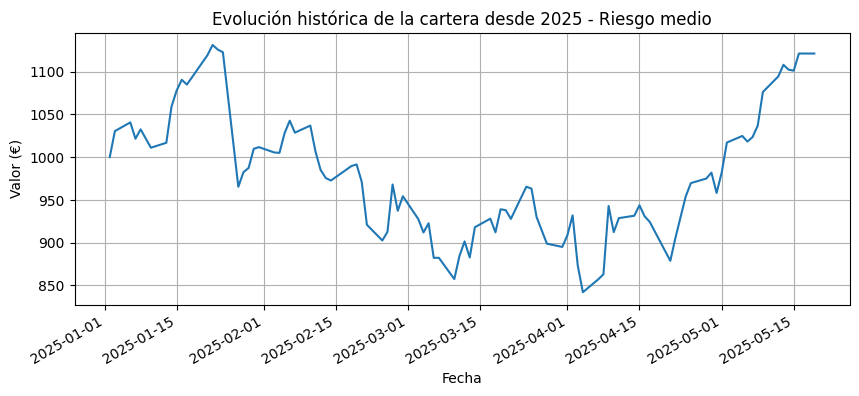

📈 Rentabilidad final estimada: 1121.01 €
📉 Máximo drawdown: -25.55% entre 2025-01-22 y 2025-04-04
🔎 Rentabilidad acumulada: 12.10%
--------------------------------------------------

## Perfil: Riesgo alto
### 📌 Composición de la cartera:
                         Empresa  Porcentaje
0  Adtalem Global Education Inc.        80.0
1        Coronado Global Res Inc        20.0


C:\Users\David\AppData\Local\Temp\ipykernel_31632\3747642941.py:108: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vol = volatilities[i]


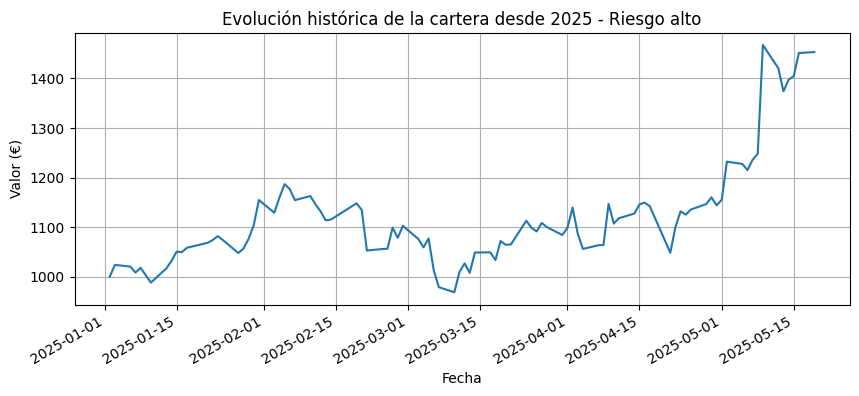

📈 Rentabilidad final estimada: 1453.00 €
📉 Máximo drawdown: -18.38% entre 2025-02-05 y 2025-03-10
🔎 Rentabilidad acumulada: 45.30%
--------------------------------------------------

## Perfil: Rentabilidad máxima
### 📌 Composición de la cartera:
                         Empresa  Porcentaje
0  Adtalem Global Education Inc.        80.0
1        Coronado Global Res Inc        20.0


C:\Users\David\AppData\Local\Temp\ipykernel_31632\3747642941.py:108: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  vol = volatilities[i]


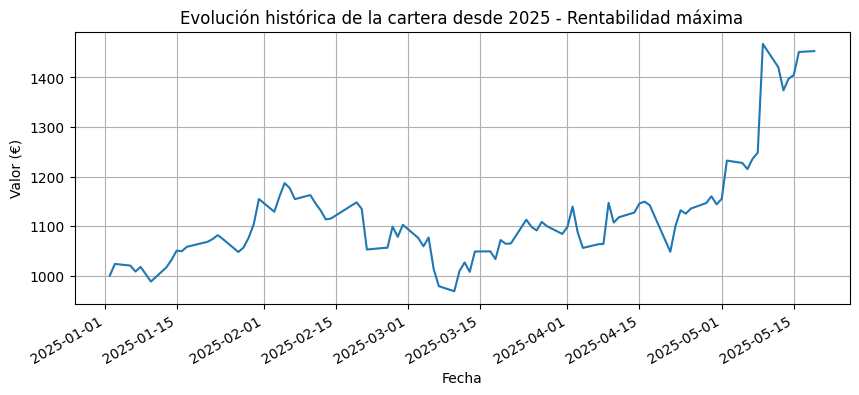

📈 Rentabilidad final estimada: 1453.00 €
📉 Máximo drawdown: -18.38% entre 2025-02-05 y 2025-03-10
🔎 Rentabilidad acumulada: 45.30%
--------------------------------------------------


In [30]:
import matplotlib.pyplot as plt
import numpy as np

perfiles = [
    "Riesgo mínimo",
    "Riesgo bajo",
    "Riesgo medio",
    "Riesgo alto",
    "Rentabilidad máxima"
]

data, tickers, names = cargar_datos()
if data.empty:
    print("No se pudo generar una cartera óptima con los datos disponibles.")
else:
    # Asegúrate de que las columnas son únicas
    data = data.loc[:, ~data.columns.duplicated()]
    # Calcula la distribución óptima con TODO el histórico
    returns = data.pct_change().dropna()
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    volatilities = returns.std() * np.sqrt(252)

    # Filtra datos desde el 1 de enero de 2025
    fecha_inicio = pd.to_datetime("2025-01-01")
    data_2025 = data[data.index >= fecha_inicio]
    if data_2025.empty:
        print("No hay datos disponibles a partir del 1 de enero de 2025.")
    else:
        inversion_inicial = 1000
        for perfil in perfiles:
            print(f"\n## Perfil: {perfil}")
            pesos = optimizar_cartera(mean_returns, cov_matrix, perfil, volatilities)
            if pesos.size == 0:
                print(f"No se pudo generar una cartera óptima para el perfil {perfil}.")
                continue

            # Composición de la cartera
            cartera = {data.columns[i]: round(pesos[i]*100, 2) for i in range(len(data.columns)) if pesos[i] > 0.001}
            ordenada = dict(sorted(cartera.items(), key=lambda x: x[1], reverse=True))
            print("### 📌 Composición de la cartera:")
            print(pd.DataFrame(ordenada.items(), columns=["Empresa", "Porcentaje"]))

            # Evolución histórica desde 2025 usando la distribución fija
            cartera_retornos = (data_2025 * pesos).sum(axis=1)
            cartera_valores = cartera_retornos / cartera_retornos.iloc[0] * inversion_inicial

            plt.figure(figsize=(10, 4))
            plt.plot(cartera_valores)
            plt.title(f"Evolución histórica de la cartera desde 2025 - {perfil}")
            plt.xlabel("Fecha")
            plt.ylabel("Valor (€)")
            plt.grid(True)
            plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            plt.gcf().autofmt_xdate()
            plt.show()
            
            # --- Cálculo correcto del drawdown y su periodo ---
            valores = cartera_valores.values
            fechas = cartera_valores.index
            
            rolling_max = np.maximum.accumulate(valores)
            drawdowns = (valores - rolling_max) / rolling_max
            
            max_drawdown = drawdowns.min()
            drawdown_min_idx = np.argmin(drawdowns)
            # El máximo anterior al drawdown mínimo
            peak_idx = np.argmax(valores[:drawdown_min_idx+1])
            drawdown_start = fechas[peak_idx]
            # El mínimo tras ese máximo (el fondo del drawdown)
            drawdown_end = fechas[drawdown_min_idx]
            
            valor_final = cartera_valores.iloc[-1]
            ganancia_pct = (valor_final - inversion_inicial) / inversion_inicial * 100
            
            print(f"📈 Rentabilidad final estimada: {valor_final:.2f} €")
            print(f"📉 Máximo drawdown: {max_drawdown*100:.2f}% entre {drawdown_start.strftime('%Y-%m-%d')} y {drawdown_end.strftime('%Y-%m-%d')}")
            print(f"🔎 Rentabilidad acumulada: {ganancia_pct:.2f}%")
            print("-" * 50)